# 0. Preliminaries 

## 0.1 Unweighed Bakctracking Of Reward

We have a tree of assistant nodes (forget about user nodes, they do not receive scores, the score just "flows" through as it is degree=1).

An assistant node $N_i$ can be a leaf node, or it can have children.
If it is a leaf node, then the leaf node's backtracked score is its local reward:

$S_i = \begin{cases} 1 & \text{if answer attempt and it is correct} \\ 0 & \text{if answer attempt and it is incorrect} \\ 0 & \text{if not answer attempt (discussion, clarification, etc.)} \end{cases}$

If $N_i$ is not a leaf node, then it has $degree$ children let's name them $N_{i,1}, N_{i,2}, \ldots, N_{i,degree}$.

$N_i$ has a backtracked score $R_i$ which is the *unweighted* mean of the backtracked scores of its children:

$S_i = \frac{1}{degree} \sum_{j=1}^{degree} S_{i,j}$

(this can be computed by backtracking the tree, starting from the leaves and going up to the root)

## 0.2 Why unweighted? Why not weigh by the likelihood of the children nodes?

We know the log-likelihood of a given child node, let's call it $LP_{i,j}$.

One could imagine applying a softmax:
$P_{i,j} = \frac{e^{LP_{i,j}}}{\sum_{k=1}^{degree} e^{LP_{i,k}}}$

This would give us a normalized likelihood for each child node. Then, we could use this likelihood to weigh the backtracked score of the child nodes:

$R_i = \sum_{j=1}^{degree} P_{i,j} \cdot R_{i,j}$

Though more "grounded" mathematically (as the reward at each node would be an expected value of reward), it does not work in practice.

This is because log-likelihoods tend to have *very wide spread*, for example three children might have $LPs = [-100, -120, -400]$.

In practice the softmax is almost always a one-hot vector. This essentially nullifies the backtracking, and the concept of making a tree.

Conclusion: for now we do unweighted backtracking.

##  0.3: From Backtracked Scores to Advantage

Once we've computed the backtracked scores for all assistant nodes, we can compute the advantage of a response in comparison to its siblings.

Assume we have a set of sibling nodes $N_{i,1}, N_{i,2}, \ldots, N_{i,degree}$ that have backtracked scores $R_{i,1}, R_{i,2}, \ldots, R_{i,degree}$.

The mean score of the siblings $\bar{R}_i = \frac{1}{degree} \sum_{j=1}^{degree} R_{i,j}$.

The advantage of a response $N_i$ in comparison to its siblings is:

$A_i = R_i - \bar{R}_i$

This is the difference between the score of the response and the mean score of its siblings.

If $A_i > 0$, then the response is better than its average sibling.

If $A_i < 0$, then the response is worse than its average sibling.

If all the siblings have the same backtrack score (for instance if all siblings are leaf nodes that either all succeeded or all failed), then the advantage of each node is 0.



## 0.4 REINFORCE Algorithm

In single-turn setups, things are simple. Given a set of responses $N_i$, their log-likelihoods $LP_i$, their backtracked scores $R_i$, their advantages $A_i$. The loss is the following:

$L = - \sum_{i=1}^{N} A_i \cdot LP_i$

Note: see the minus in the loss, so this is equivalent to maximizing the dot product of advantages and log-likelihoods.

By minimizing this loss it optimizes the model to have:
- Responses with positive advantage ($A_i > 0$) see their log-likelihoods ($LP_i$) increase
- Responses with negative advantage ($A_i < 0$) see their log-likelihoods ($LP_i$) decrease

In multi-turn setups, things are more complex. We have to perform the REINFORCE algorithm for each sibling set.
Imagine we have a tree with a depth of $Depth=5$ and we use a branching degree factor of $Degree=3$, then there are $3^1+3^2+3^3+3^4+3^5=364$ assistant nodes that form $3^0+3^1+3^2+3^3+3^4=121$ sibling sets.

Each sibling set (common direct parent $N_i$) with nodes $N_{i,1}, N_{i,2}, \ldots, N_{i,degree}$ can be used to perform a REINFORCE update (by computing a loss $L_i$ and performing a gradient update).

There are now (at least) three ways to perform updates.

- **[Method 1: Global Single Update]** This consists in summing all the losses $L = \sum_{i=1}^{N} L_i$ and performing *a single* gradient update based on the entire tree.

- **[Method 2: Per-Sibling Update; Leaf-to-Root]** This consists in performing a gradient update (`loss.backward() & optimizer.step()`) for each sibling set, going from the deepest sibling sets back to the root.

- **[Method 3: Per-Sibling Update; Root-to-Leaf]** This consists in performing a gradient update (`loss.backward() & optimizer.step()`) for each sibling set, going from the root to the deepest sibling sets.


Note on differences:
- Method 1 is the only truly **online** method. As Methods 2/3 make multiple updates per generated tree, making the model gradually more offline. However, Method 1 only applies a single gradient update per tree. Trees can take minutes to compute and contain 100-1000 assistant responses, so it's a high-cost to pay to do only one update.
- Method 2 & 3 are both somewhat "online", but it feels like Method 2 is "more online" than Method 3. That is because we are in some way "unpeeling" the rollout in order. First updating model behavior for the leaf nodes, and then for $max\_depth - 1$, etc back to the root. On the other hand, Method 3 first updates the root behavior, which might make the entire trajectories less likely, making subsequent deeper updates more offline.

All experiments conducted so far have been using Method 2, but emperical experimentation with Method 1 & 3 should be conducted to see the effect.

Additional Considerations:
There are potentially dimensions to consider besides grouping and ordering of updates. Currently we skip sibling sets where no advantage is observed ($A_{i,j} = 0$) for all siblings. This can occur when all siblings fail or succeed equally.
Here are additional possibilities for filtering of updates:

- **[Consideration 1: Skip Leaf Updates]**. Updates on the leaf nodes reveal which answers are correct and incorrect, which can potentially lead to overfitting, particularly if we use the same instructions (samples) many times (10+ epochs). On the other hand, non-leaf updates are more behavioral. Non-leaf siblings have positive advantage only when they indirectly help their children succeed more frequently, which does not reveal answer correctness as obviously.
- **[Consideration 2: Use Statistical Methods to Estimate Advantage Gap Significance]**. We estimate advantage with a (relatively) low degree. Therefore if we find that a node has very small advantage over another (say an advantage gap of 0.02), it might not be statistically significant, and could be detrimental to model training. If we have a principled way to estimate uncertainty of the advantage between sibling sets, we could use that to decide which updates to skip.

## 0.5 Backtracking Full Distributions for Subdegree Estimation

We are trying to gain statistical understanding on the reliability/variability of the backtracked scores.

This is important in order to: (1) decide on the degree required in tree generation, (2) potentially decide which backprops to run, and which to skip (if we have a sense of significance of advantage).

True advantage (and backtrack score) calculation requires running with infinite degree, this will give the true advantage of a response but is computationally intractable.

What we do is *estimate* the advantage by running with a finite degree. The higher the degree, the more accurate the estimate.

For statistical analysis, we can generate trees with high degree ($degree=8$), and we can observe the distirbution over the scores if we had lower degree (by observing subtrees of lower degree).

(Note a generating a tree with degree 8 and depth 5 yields 10-30k assistant nodes... each one of these is an LLM response, not counting user nodes which are also generated).

In order to effectively understand variability/reliability of score backtracking, we can use a mega-tree and backtrack for distributions of scores for any subdegree.

Here's a practical example. Imagine we have a tree with depth 3 and degree 3.

<!-- let's do it with ASCII art -->
```
Root
├── N_{1} (backtracked score: 0.66)
│   ├── N_{1,1} (backtracked score: 0.33)
│   │   ├── N_{1,1,1} (leaf node score: 1)
│   │   ├── N_{1,1,2} (leaf node score: 0)
│   │   └── N_{1,1,3} (leaf node score: 0)
│   └── N_{1,2} (backtracked score: 0.66)
│       ├── N_{1,2,1} (leaf node score: 1)
│       ├── N_{1,2,2} (leaf node score: 0)
│       └── N_{1,2,3} (leaf node score: 1)
│   └── N_{1,3} (backtracked score: 1)
│       ├── N_{1,3,1} (leaf node score: 1)
│       ├── N_{1,3,2} (leaf node score: 1)
│       └── N_{1,3,3} (leaf node score: 1)
├── N_{2} (backtracked score: 0.776)
│   ├── N_{2,1} (backtracked score: 0.33)
│   │   ├── N_{2,1,1} (leaf node score: 0)
│   │   └── N_{2,1,2} (leaf node score: 1)
│   │   └── N_{2,1,3} (leaf node score: 0)
│   └── N_{2,2} (backtracked score: 1)
│       ├── N_{2,2,1} (leaf node score: 1)
│       └── N_{2,2,2} (leaf node score: 1)
│       └── N_{2,2,3} (leaf node score: 1)
│   └── N_{2,3} (backtracked score: 1)
│       ├── N_{2,3,1} (leaf node score: 1)
│       └── N_{2,3,2} (leaf node score: 1)
│       └── N_{2,3,3} (leaf node score: 1)
├── N_{3} (backtracked score: 0.33)
[...]
```

Then now, let's consider computing score distributions for subdegree of 2.

First, leaf nodes are simple, they are point distributions:

$P(S_{1,1,1} = 1) = 1$
$P(S_{1,1,2} = 0) = 0$
$P(S_{1,1,3} = 0) = 0$

We denote these as key-value dictionaries: $D^{2}_{1,1,1} = \{1: 1.0\}, D^{2}_{1,1,2} = \{0: 1.0\}, D^{2}_{1,1,3} = \{1.0: 1.0\}$
(the 2 here is to indicate the subdegree of 2)

Now we can backpropagate entire distributions by taking subsets of children, and computing the parent distrition. Specifically for any subset of degree $subdegree$, we can add to the parent distribution:
- If we select $N_{1,1,1}$ and $N_{1,1,2}$ then $S_{1,1} = 0.5$
- If we select $N_{1,1,1}$ and $N_{1,1,3}$ then $S_{1,1} = 0.5$
- If we select $N_{1,1,2}$ and $N_{1,1,3}$ then $S_{1,1} = 0.0$

Therefore, $D^{2}_{1,1} = \{0.5: 0.66, 0.0: 0.33\}$
Similarly, we can compute $D^{2}_{1,2} = \{0.5: 0.66, 1.0: 0.33\}$ and $D^{2}_{1,3} = \{1.0: 1.0\}$.

And we can now continue our distribution backpropagation to the $N_{1}$ node:
- If we select $N_{1,1}$ and $N_{1,2}$ then $D^{2}_{1} = \{0.5: 0.5555, 0.25: 0.2222, 0.75: 0.2222\}$ (basically there is a 0.66*0.66 chance of select 0.5 / 0.5; a 0.33*0.33 chance of selecting 1/0 which averages to 0.5; and then a 0.33*0.66 chance of selecting 0.5/0, and finally a 0.66*0.33 changce of selecting 0.5/1 which averages to 0.75)
- If we select $N_{1,1}$ and $N_{1,3}$ then $D^{2}_{1} = \{0.75: 0.66, 0.5: 0.33\}$ two thirds of a chance to take on value 0.75 (average of 0.5 and 1), and a third of a chance to take on value 0.5 (average of 0 and 1)
- If we select $N_{1,2}$ and $N_{1,3}$ then $D^{2}_{1} = \{0.75: 0.66, 1: 0.33\}$ two thirds of a chance to take on 0.75 (average of 0.5 and 1), and a third of a chance to take on value 1 (average of 1 and 1)

Now, we can just take the mean of these distributions, assuming we count all subtrees as equally likely, to get:
$D^{2}_{1} = \{0.25: 0.074, 0.5: 0.296, 0.75: 0.518, 1: 0.111\}$.

(this miraculously adds to 1... so Philippe did not make a mistake when calculating this manually)

Note that this distribution backtrack trick is essential. Trying to "list out" all subtrees of a given subdegree at a given node is computationally intractable. Backtracking is wonderful.

Now these backtracked full distributions of a given subdegree can be used to understand the effect of using a lower degree would have on the variance of the estimate of the backtracked score.
In particular, the distribution can be used to compute the estimate mean, variance, standard deviation, and percentiles.

These are the plots that we will see in the next section!






# 1. Variability of Score At Nodes / Depth; based on Mega Tree (degree=8)

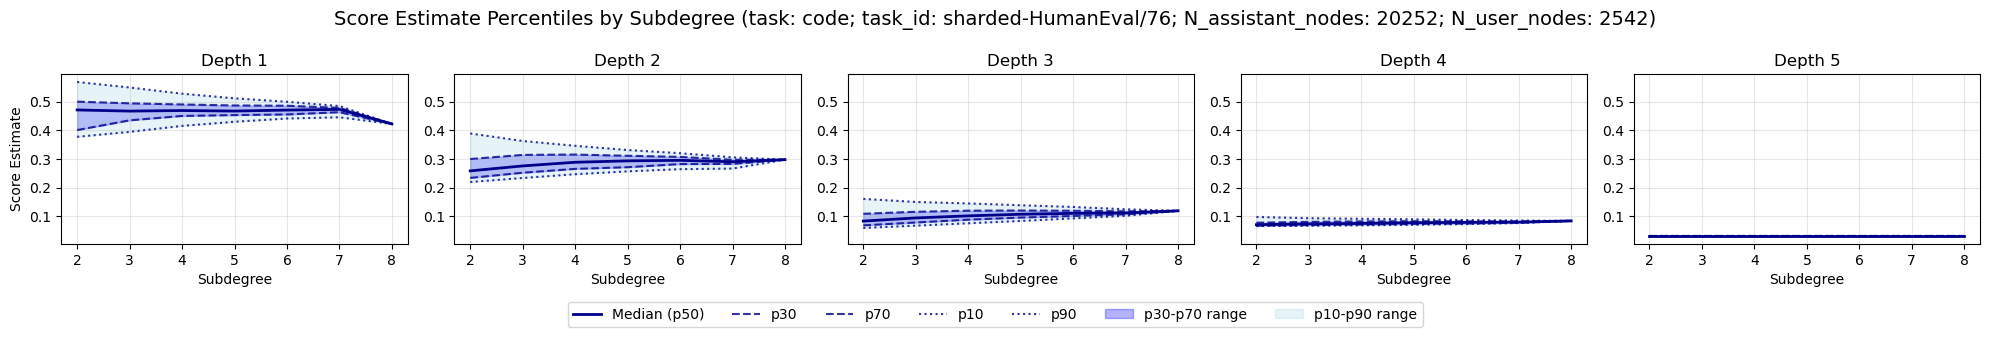

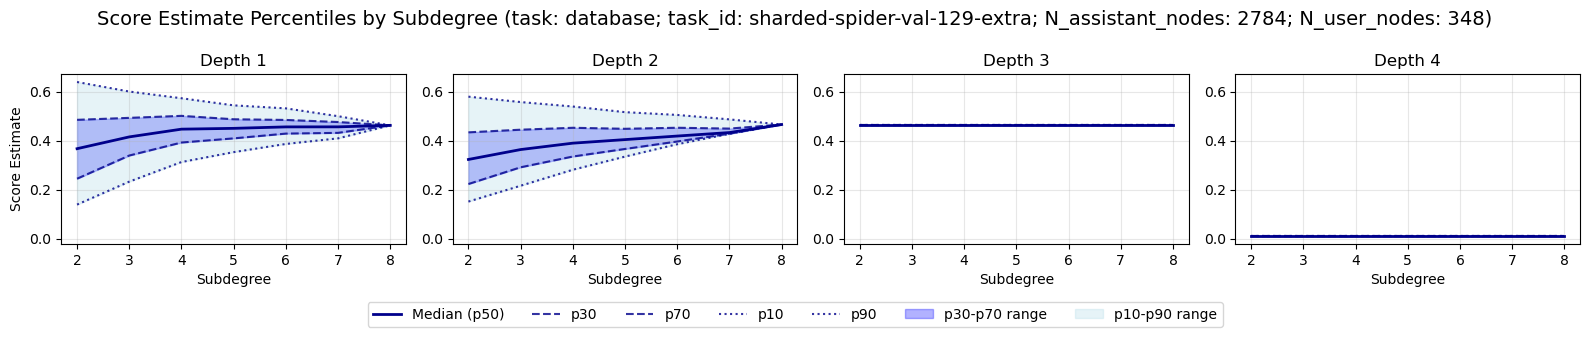

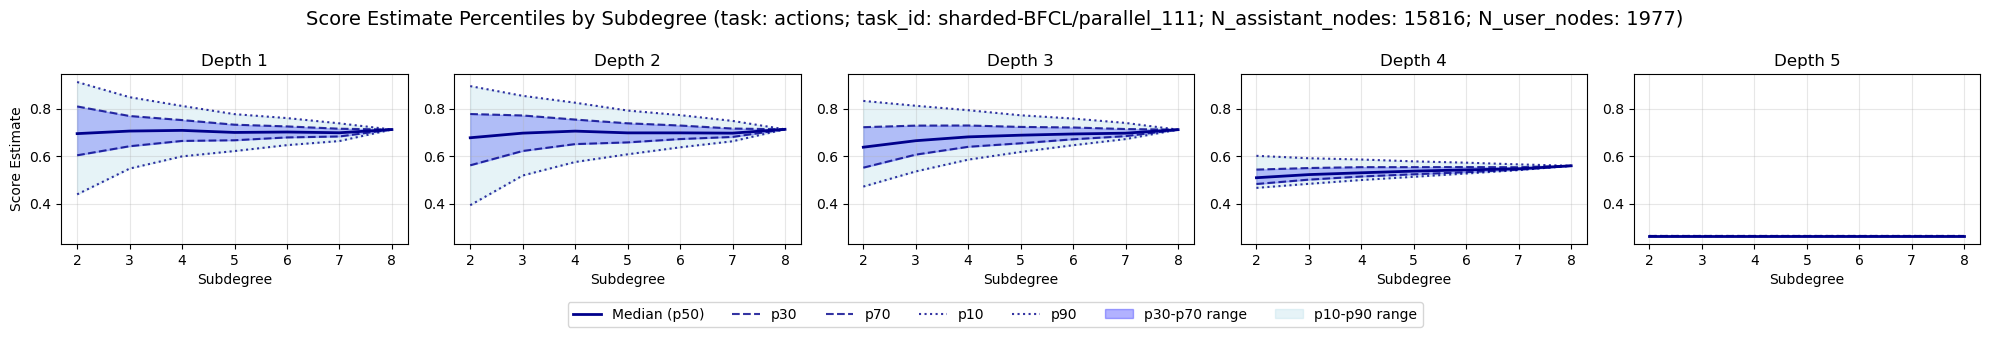

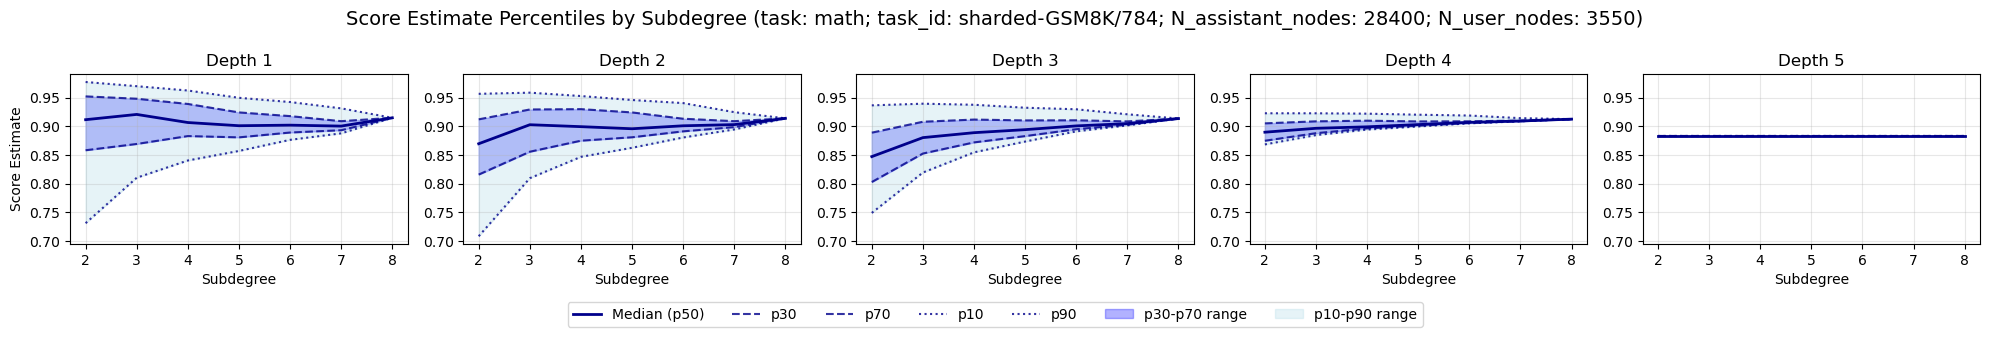

In [11]:
from utils_tree import compute_percentiles
import json, numpy as np
from matplotlib import pyplot as plt
from collections import Counter

def plot_score_estimate_percentiles(sample_log):
    tree = sample_log["trace"]
    user_nodes = [n for n in tree if n["role"] == "user"]
    max_degree = max([len(n["children"]) for n in user_nodes])

    assistant_nodes = [n for n in tree if n["role"] == "assistant"]
    max_depth = max([n["depth"] for n in assistant_nodes])

    # Store percentiles for each depth and subdegree
    depth_percentiles = {d: {subdegree: {'p10': [], 'p30': [], 'p50': [], 'p70': [], 'p90': []} 
                            for subdegree in range(2, max_degree + 1)} 
                        for d in range(1, max_depth + 1)}

    for anode in assistant_nodes:
        for subdegree in range(2, max_degree + 1):
            # fix the distrib as the keys have been turned into strings
            distrib = Counter({float(k): v for k, v in anode[f"score_estimate_deg{subdegree}"].items()})
            
            # Compute percentiles
            percentiles = compute_percentiles(distrib, [0.1, 0.3, 0.5, 0.7, 0.9])
            p10, p30, p50, p70, p90 = percentiles
            
            depth_percentiles[anode["depth"]][subdegree]['p10'].append(p10)
            depth_percentiles[anode["depth"]][subdegree]['p30'].append(p30)
            depth_percentiles[anode["depth"]][subdegree]['p50'].append(p50)
            depth_percentiles[anode["depth"]][subdegree]['p70'].append(p70)
            depth_percentiles[anode["depth"]][subdegree]['p90'].append(p90)

    # First, collect all data across all depths to determine global y-axis range
    all_data_points = []
    depth_data = {}
    
    for depth in range(1, max_depth + 1):
        subdegrees = list(range(2, max_degree + 1))
        
        # Calculate averages across all nodes at this depth for each percentile
        p10_avg = [np.mean(depth_percentiles[depth][subdegree]['p10']) if depth_percentiles[depth][subdegree]['p10'] else 0 
                for subdegree in subdegrees]
        p30_avg = [np.mean(depth_percentiles[depth][subdegree]['p30']) if depth_percentiles[depth][subdegree]['p30'] else 0 
                for subdegree in subdegrees]
        p50_avg = [np.mean(depth_percentiles[depth][subdegree]['p50']) if depth_percentiles[depth][subdegree]['p50'] else 0 
                for subdegree in subdegrees]
        p70_avg = [np.mean(depth_percentiles[depth][subdegree]['p70']) if depth_percentiles[depth][subdegree]['p70'] else 0 
                for subdegree in subdegrees]
        p90_avg = [np.mean(depth_percentiles[depth][subdegree]['p90']) if depth_percentiles[depth][subdegree]['p90'] else 0 
                for subdegree in subdegrees]
        
        # Store data for this depth
        depth_data[depth] = {
            'subdegrees': subdegrees,
            'p10_avg': p10_avg,
            'p30_avg': p30_avg,
            'p50_avg': p50_avg,
            'p70_avg': p70_avg,
            'p90_avg': p90_avg
        }
        
        # Collect all data points for global range calculation
        all_data_points.extend(p10_avg + p30_avg + p50_avg + p70_avg + p90_avg)
    
    # Calculate global y-axis range
    global_y_min = min(all_data_points)
    global_y_max = max(all_data_points)
    
    # Add some padding to the range
    y_range = global_y_max - global_y_min
    padding = y_range * 0.05  # 5% padding
    global_y_min -= padding
    global_y_max += padding

    # Create subplots for all depths in one figure
    fig, axes = plt.subplots(1, max_depth, figsize=(max_depth * 4, 3))

    # If there's only one depth, make axes iterable
    if max_depth == 1:
        axes = [axes]

    for depth_idx, depth in enumerate(range(1, max_depth + 1)):
        ax = axes[depth_idx]
        
        # Get pre-calculated data for this depth
        data = depth_data[depth]
        subdegrees = data['subdegrees']
        p10_avg = data['p10_avg']
        p30_avg = data['p30_avg']
        p50_avg = data['p50_avg']
        p70_avg = data['p70_avg']
        p90_avg = data['p90_avg']
        
        # Plot the median (p50) as solid line
        ax.plot(subdegrees, p50_avg, color='darkblue', linewidth=2, label='Median (p50)', linestyle='-')
        
        # Plot p30-p70 range as dashed lines
        ax.plot(subdegrees, p30_avg, color='darkblue', linestyle='--', alpha=0.8, label='p30')
        ax.plot(subdegrees, p70_avg, color='darkblue', linestyle='--', alpha=0.8, label='p70')
        
        # Plot p10-p90 range as dotted lines
        ax.plot(subdegrees, p10_avg, color='darkblue', linestyle=':', alpha=0.8, label='p10')
        ax.plot(subdegrees, p90_avg, color='darkblue', linestyle=':', alpha=0.8, label='p90')
        
        # Fill regions with alpha=0.3
        ax.fill_between(subdegrees, p30_avg, p70_avg, color='blue', alpha=0.3, label='p30-p70 range')
        ax.fill_between(subdegrees, p10_avg, p90_avg, color='lightblue', alpha=0.3, label='p10-p90 range')
        
        # Labels and title
        ax.set_xlabel('Subdegree')
        if depth_idx == 0:  # Only set ylabel for the leftmost subplot
            ax.set_ylabel('Score Estimate')
        ax.set_title(f'Depth {depth}')
        ax.grid(True, alpha=0.3)
        
        # Set integer ticks for x-axis
        ax.set_xticks(subdegrees)
        
        # Set the same y-axis range for all subplots
        ax.set_ylim(global_y_min, global_y_max)

    # Create a single legend at the bottom
    handles, labels = axes[0].get_legend_handles_labels()

    fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, -0.1), ncol=len(labels))

    N_assistant_nodes = len([n for n in tree if n["role"] == "assistant"])
    N_user_nodes = len([n for n in tree if n["role"] == "user"])

    plt.suptitle(f"Score Estimate Percentiles by Subdegree (task: {sample_log['task']}; task_id: {sample_log['task_id']}; N_assistant_nodes: {N_assistant_nodes}; N_user_nodes: {N_user_nodes})", fontsize=14)
    plt.tight_layout()
    plt.subplots_adjust(bottom=0.2)  # Make room for the legend
    plt.show()

# tree_logs_file = "experiments/exp_20250605_3/tree_logs.jsonl"
tree_logs_file = "experiments/off0610_B_1/tree_logs.jsonl"

with open(tree_logs_file, "r") as f:
    data = [json.loads(line) for line in f]

for sample_log in data:
    plot_score_estimate_percentiles(sample_log)


# 2. Flip Analysis Based on Gold-Standard Gap

Given $N_i$ and $N_j$ that have gold standard reward $R_i^*$ and $R_j^*$ (based on full mega-tree backtrack of degree 8).

$gap^* = R_j^*-R_i^*$

Now take subtrees (with $N_i$ and $N_j$ as roots) and of smaller subdegree (2 <= subdegree < 7) and use backtracking to compute $R_i'$ and $R_j'$
$gap' = R_j'-R_i'$

Now what is the likelihood that:
sign($gap'$) != sign($gap^*$)

In other words: though we know $R_i^* > R_j^*$ (by at least some gap level), what's the likelihood that we would emperically find that $R_i' \leq R_j'$ (because of lack of precision due to smaller subdegree)?

Note, this can be computed efficiently by just using the backtracked distributions of the subdegrees (!!).

In [12]:
import json, itertools

with open("experiments/exp_20250605_3/tree_logs.jsonl", "r") as f:
    data = [json.loads(line) for line in f]

tree = data[0]["trace"]

user_nodes = [n for n in tree if n["role"] == "user"]
max_degree = max([len(n["children"]) for n in user_nodes])

assistant_nodes = [n for n in tree if n["role"] == "assistant"]
max_depth = max([n["depth"] for n in assistant_nodes])

for anode in assistant_nodes:
    for subdegree in range(2, max_degree + 1):
        anode[f"score_estimate_deg{subdegree}"] = {float(k): v for k, v in anode[f"score_estimate_deg{subdegree}"].items()}

reward_gap_ranges = [[0.01, 0.1], [0.1, 0.2], [0.2, 0.3], [0.3, 0.4], [0.4, 0.5], [0.5, 0.6], [0.6, 0.7], [0.7, 0.8], [0.8, 0.9], [0.9, 1.0]]
subdegrees = list(range(2, max_degree + 1))

bin2pairs = {idx: [] for idx in range(len(reward_gap_ranges))}

for user_node in user_nodes:
    assistant_node_ids = user_node["children"]
    children_assistant_nodes = [n for n in assistant_nodes if n["id"] in assistant_node_ids]
    children_assistant_nodes = sorted(children_assistant_nodes, key=lambda n: n["backpropagated_score"])
    for n1, n2 in itertools.combinations(children_assistant_nodes, 2):
        R1 = n1["backpropagated_score"]
        R2 = n2["backpropagated_score"]

        gap = R2 - R1
        bin_idx = -1
        for idx, rg in enumerate(reward_gap_ranges):
            if rg[0] <= gap <= rg[1]:
                bin_idx = idx
                break
        if bin_idx != -1:
            bin2pairs[bin_idx].append((n1, n2))

In [16]:
from utils_tree import compute_probability_flip
from IPython.display import display
import numpy as np, pandas as pd

for bin_idx, bin in enumerate(reward_gap_ranges):
    bin_flip_probs = {depth: {subdegree: [] for subdegree in range(2, max_degree + 1)} for depth in range(1, max_depth + 1)}
    for n1, n2 in bin2pairs[bin_idx]:
        pair_depth = n1["depth"]

        for subdegree in range(2, max_degree + 1):
            distrib1 = n1[f"score_estimate_deg{subdegree}"]
            distrib2 = n2[f"score_estimate_deg{subdegree}"]
            flip_prob = compute_probability_flip(distrib1, distrib2, strict_flip=False)
            bin_flip_probs[pair_depth][subdegree].append(flip_prob)
    
    # take means
    rows = []
    for depth in range(1, max_depth + 1):
        row = {"depth": depth, "N_matching_pairs": len(bin_flip_probs[depth][subdegree])}
        for subdegree in range(2, max_degree + 1):
            row[f"deg{subdegree}"] = 100.0 * ( 1.0 - np.mean(bin_flip_probs[depth][subdegree]))
        if row["N_matching_pairs"] > 0:
            rows.append(row)

    df = pd.DataFrame(rows).set_index("depth")
    df = df.style.background_gradient(cmap='Blues', subset=pd.IndexSlice[:, 'deg2':f'deg{max_degree}'], vmin=0.0, vmax=100.0).format({f'deg{i}': '{:.2f}' for i in range(2, max_degree + 1)}).set_caption(f"Reproducibility of pairwise reward reliability at gap of [{reward_gap_ranges[bin_idx][0]} -> {reward_gap_ranges[bin_idx][1]}]")

    display(df)

/home/plaban/anaconda3/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/plaban/anaconda3/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


,N_matching_pairs,deg2,deg3,deg4,deg5,deg6,deg7,deg8
depth,,,,,,,,
1,12,37.40,53.69,59.33,65.44,71.81,79.93,91.67
2,101,21.51,40.64,54.12,65.77,74.92,84.37,90.10
3,520,16.26,30.24,44.46,57.87,70.60,83.70,84.81


,N_matching_pairs,deg2,deg3,deg4,deg5,deg6,deg7,deg8
depth,,,,,,,,
1,11,61.58,81.40,87.86,93.14,96.22,98.18,100.00
2,20,41.84,65.98,81.16,88.85,94.04,97.42,100.00
3,197,32.27,46.37,58.56,69.30,79.19,88.79,100.00
4,1508,26.54,38.39,50.00,61.61,73.46,85.89,100.00


,N_matching_pairs,deg2,deg3,deg4,deg5,deg6,deg7,deg8
depth,,,,,,,,
2,8,70.21,87.56,95.03,98.61,99.92,100.00,100.00
3,75,54.43,71.78,83.07,90.51,95.95,100.00,100.00
4,344,47.71,63.46,76.29,86.62,94.61,100.00,100.00


,N_matching_pairs,deg2,deg3,deg4,deg5,deg6,deg7,deg8
depth,,,,,,,,
2,19,78.35,94.69,99.05,99.90,100.00,100.00,100.00
3,56,69.13,84.04,92.43,97.43,100.00,100.00,100.00
4,147,64.02,79.53,90.00,96.64,100.00,100.00,100.00


,N_matching_pairs,deg2,deg3,deg4,deg5,deg6,deg7,deg8
depth,,,,,,,,
2,10,87.77,98.27,99.84,100.00,100.00,100.00,100.00
3,26,82.06,94.66,98.82,100.00,100.00,100.00,100.00
4,67,77.15,90.66,97.43,100.00,100.00,100.00,100.00


,N_matching_pairs,deg2,deg3,deg4,deg5,deg6,deg7,deg8
depth,,,,,,,,
3,11,93.50,99.42,99.99,100.00,100.00,100.00,100.00


,N_matching_pairs,deg2,deg3,deg4,deg5,deg6,deg7,deg8
depth,,,,,,,,
2,5,99.12,100.00,100.00,100.00,100.00,100.00,100.00
3,8,92.23,98.76,100.00,100.00,100.00,100.00,100.00
4,47,87.46,97.07,100.00,100.00,100.00,100.00,100.00


,N_matching_pairs,deg2,deg3,deg4,deg5,deg6,deg7,deg8
depth,,,,,,,,
2,1,98.41,100.00,100.00,100.00,100.00,100.00,100.00
3,17,98.50,100.00,100.00,100.00,100.00,100.00,100.00
4,26,96.02,100.00,100.00,100.00,100.00,100.00,100.00


,N_matching_pairs,deg2,deg3,deg4,deg5,deg6,deg7,deg8
depth,,,,,,,,
2,6,99.83,100.00,100.00,100.00,100.00,100.00,100.00
3,9,99.80,100.00,100.00,100.00,100.00,100.00,100.00
4,31,100.00,100.00,100.00,100.00,100.00,100.00,100.00


,N_matching_pairs,deg2,deg3,deg4,deg5,deg6,deg7,deg8
depth,,,,,,,,
3,28,100.00,100.00,100.00,100.00,100.00,100.00,100.00
4,564,100.00,100.00,100.00,100.00,100.00,100.00,100.00
5,4071,100.00,100.00,100.00,100.00,100.00,100.00,100.00


# Reversed Flip Analysis (more correct)

Given $N_i$ and $N_j$ and a subdegree $D$, we can compute a distribution over gaps of the backtracked scores.

Then we can observe what the *true gap* is (based on the gold standard scores with the maximal degree) and we can calculate the likelihood of predicting preference with a gap of some amount (say [0.3, 0.4]) that is incorrect (does not match the sign of the true gap).


In [15]:
from utils_tree import compute_gap_distribution, compute_binned_gap_distribution
import json, itertools, numpy as np

with open("experiments/exp_20250605_3/tree_logs.jsonl", "r") as f:
    data = [json.loads(line) for line in f]

tree = data[0]["trace"]

user_nodes = [n for n in tree if n["role"] == "user"]
max_degree = max([len(n["children"]) for n in user_nodes])

assistant_nodes = [n for n in tree if n["role"] == "assistant"]
max_depth = max([n["depth"] for n in assistant_nodes])

for anode in assistant_nodes:
    for subdegree in range(2, max_degree + 1): # reloading because it's saved funny
        anode[f"score_estimate_deg{subdegree}"] = {float(k): v for k, v in anode[f"score_estimate_deg{subdegree}"].items()}

score_bins = [(0.01, 0.1), (0.1, 0.2), (0.2, 0.3), (0.3, 0.4), (0.4, 0.5), (0.5, 0.6), (0.6, 0.7), (0.7, 0.8), (0.8, 0.9), (0.9, 1.0)]

negative_bins = [(-b, -a) for a, b in score_bins][::-1]

gap_bins = negative_bins + [(-0.01, 0.01)] + score_bins
subdegrees = list(range(2, max_degree))

bin_flip_probs = {depth: {subdegree: {bin: [] for bin in score_bins} for subdegree in range(2, max_degree + 1)} for depth in range(1, max_depth + 1)}

for user_node in user_nodes: # [:10]
    assistant_node_ids = user_node["children"]
    children_assistant_nodes = [n for n in assistant_nodes if n["id"] in assistant_node_ids]
    children_assistant_nodes = sorted(children_assistant_nodes, key=lambda n: n["backpropagated_score"])
    for n1, n2 in itertools.combinations(children_assistant_nodes, 2):
        R1 = n1["backpropagated_score"]
        R2 = n2["backpropagated_score"]
        real_gap = R2 - R1
        assert real_gap >= 0, "this should be the case because we've sorted the nodes"

        # print("-"*100)
        # print(user_node["id"], n1["id"], n2["id"], real_gap)
        for subdegree in subdegrees:
            D1 = n1[f"score_estimate_deg{subdegree}"]
            D2 = n2[f"score_estimate_deg{subdegree}"]
            gap_distribution = compute_gap_distribution(D1, D2)
            binned_gap_distribution = compute_binned_gap_distribution(gap_distribution, gap_bins)
            # print("    ", subdegree, binned_gap_distribution)

            for bin in negative_bins:
                if bin in binned_gap_distribution:
                    positive_bin = (-bin[1], -bin[0])
                    bin_flip_probs[user_node["depth"]][subdegree][positive_bin].append(binned_gap_distribution[bin])

bin_flip_probs = {depth: {subdegree: {bin: 0.0 if len(probs) == 0 else np.mean(probs) for bin, probs in bin_flip_probs[depth][subdegree].items()} for subdegree in range(2, max_degree + 1)} for depth in range(1, max_depth + 1)}

bin_flip_probs


{1: {2: {(0.01, 0.1): 0.07961855948673201,
   (0.1, 0.2): 0.06849859835600612,
   (0.2, 0.3): 0.030589010361790826,
   (0.3, 0.4): 0.008986772959999846,
   (0.4, 0.5): 0.009270227276677185,
   (0.5, 0.6): 0.0023344419833113634,
   (0.6, 0.7): 0.002478879549148542,
   (0.7, 0.8): 0.000847889629955285,
   (0.8, 0.9): 8.964369785073166e-05,
   (0.9, 1.0): 3.9020498360768806e-05},
  3: {(0.01, 0.1): 0.21764144695307808,
   (0.1, 0.2): 0.03975625025436689,
   (0.2, 0.3): 0.012156179171564606,
   (0.3, 0.4): 0.007670907643067798,
   (0.4, 0.5): 0.00245087942485169,
   (0.5, 0.6): 4.245107343460464e-05,
   (0.6, 0.7): 0.0,
   (0.7, 0.8): 0.0,
   (0.8, 0.9): 0.0,
   (0.9, 1.0): 0.0},
  4: {(0.01, 0.1): 0.2048200299351288,
   (0.1, 0.2): 0.022636526439454394,
   (0.2, 0.3): 0.028260835843378157,
   (0.3, 0.4): 0.0003338783596138522,
   (0.4, 0.5): 0.0,
   (0.5, 0.6): 0.0,
   (0.6, 0.7): 0.0,
   (0.7, 0.8): 0.0,
   (0.8, 0.9): 0.0,
   (0.9, 1.0): 0.0},
  5: {(0.01, 0.1): 0.18053864629128014,
   